In [1]:
from tools import *
from figure_2D import *
from figure_3D import *
from images import *

In [2]:
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import *
from visualization_helper import *

In [3]:
from meshes_meta import saddle,  igloo_coarse,\
                        squid,   igloo,       \
                        peanut,  lilium,      \
                        hive,    trililium

### **Mesh Path**

In [4]:
mesh_path, nb_units = peanut

### **Active Units** and **Target Percent**

In [5]:
# deployed_cells  = list(range(nb_units))
deployed_cells  = [7, 32, 56]
deployed_percent = 100
undeployed_cells  = []

In [6]:
active_units    = deployed_cells + undeployed_cells
target_percents = [deployed_percent]*len(deployed_cells) + [0]*len(undeployed_cells) # 0:undeployed | 100:deployed

---

In [7]:
io, input_data, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier = parse_input(mesh_path, handleBoundary = False, isHex = False, use_target_surface = False)
# if `use_target_surface=True`, no need to activate any units

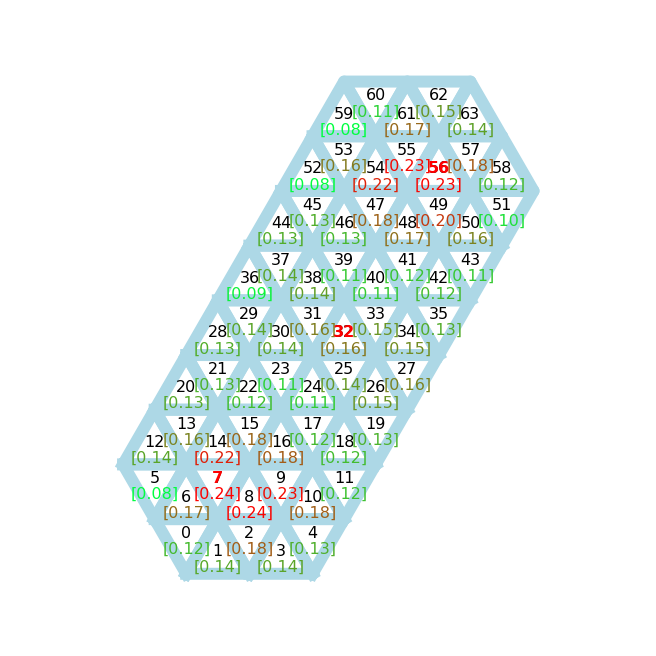

In [8]:
plot_undeployed_2D(input_data,
                   curr_um,
                   show_height=True,
                   active_cells=active_units,
                   target_percents=target_percents,
                   file_name = '',
                   show_plot=True)

In [9]:
curr_um_undep = curr_um

In [10]:
curr_um_undep.umbrellaHeights.min(), curr_um_undep.umbrellaHeights.max()

(0.08163767786194934, 0.23826839615216408)

In [11]:
view_undep = plot3D(curr_um_undep, input_data)
view_undep.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [12]:
view3D = plot3D(curr_um, input_data)
view3D.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [13]:
rod_colors = get_color_field(curr_um, input_data, uidBased = False)

In [14]:
init_center_pos = get_center_position(curr_um)
init_heights = curr_um.umbrellaHeights

In [15]:
dep_weights              = set_actives_dep_weights(curr_um.numUmbrellas(), active_units)
target_heights           = percent_to_height(init_heights, plate_thickness_scaled, active_units, target_percents)
target_height_multiplier = set_target_height(curr_um.numUmbrellas(), plate_thickness_scaled, active_units, target_heights)

In [16]:
success, eqays = deploy_umbrella_pin_rigid_motion(curr_um, plate_thickness_scaled, target_height_multiplier, view3D, rod_colors, analysis = True, dep_weights=dep_weights); success

True

In [17]:
is_plate_collided = curr_um.umbrellaHeights < plate_thickness_scaled
if (is_plate_collided.any()):
    print("[KO] : /!\ plates enter each others /!\\")
    print(f'{plate_thickness_scaled = }')
    print(*zip(*np.where(is_plate_collided), curr_um.umbrellaHeights[is_plate_collided]), sep='\n')
else: print("[OK]: plates are fine")

[KO] : /!\ plates enter each others /!\
plate_thickness_scaled = 0.008268248265160394
(0, 0.007814845053908876)
(33, 0.008104545456671924)
(51, 0.007467794918718059)


In [18]:
# eqays.plot()
curr_um.energy(), curr_um.energyElastic()

(-2.9999311220745475, 6.882512975199542e-05)

In [19]:
stress_type = 'VonMises'
sview_vm = plot3D_stress(curr_um, stress_type)
sview_vm.show()

VonMises Stresses Extrem values:
    max : 5.37e+01
    min : 0.00e+00


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

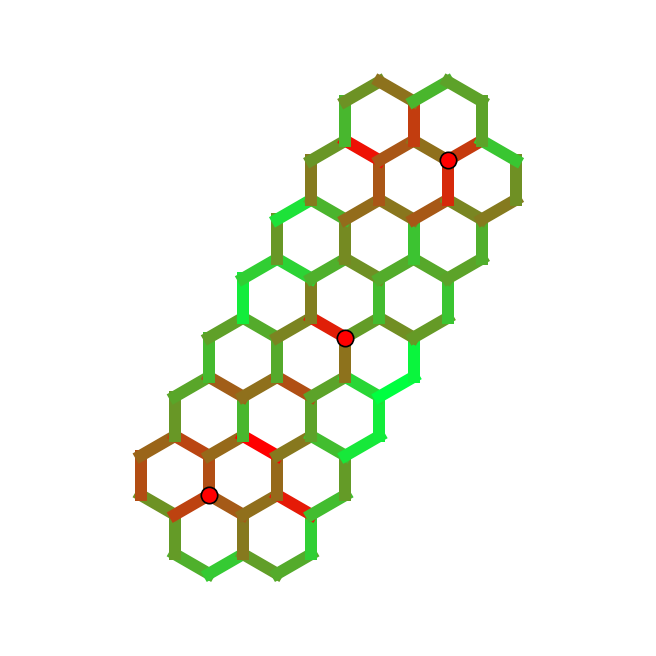

In [20]:
plot2D_stress(curr_um, input_data['umbrella_connectivity'], init_center_pos, active_units, target_percents, stress_type=stress_type, show_percent=False)

In [21]:
import open3d as o3d
points = curr_um.XJointPositions().reshape(-1,3)
midpos = 0.5*(curr_um.topJointPositions() + curr_um.bottomJointPositions()).reshape(-1,3)
points = np.concatenate((points, midpos), axis = 0)
pcd = o3d.t.geometry.PointCloud(o3d.core.Tensor(points))
o3d.t.io.write_point_cloud("pointcloud.pcd", pcd)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


True

In [22]:
import bspline_fitting, mesh
bspline_fitting.bspline_fitting("pointcloud.pcd", "out.obj")
surface_mesh = o3d.io.read_triangle_mesh("out.obj")
surface_mesh = mesh.Mesh(np.asarray(surface_mesh.vertices),np.asarray(surface_mesh.triangles))

In [23]:
view = linkage_vis.LinkageViewerWithSurface(curr_um, surface_mesh, width=1024, height=600)
set_surface_view_options(view, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
view.averagedMaterialFrames = True
view.showScalarField(rod_colors)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.7066666666666668, children=(PointLight(color='#999999', position=(0…

In [24]:
import registration
R, t = registration.register_points(curr_um.XJointPositions().reshape(-1,3), curr_um.XJointTgtPositions().reshape(-1,3))

In [25]:
norme_t = np.linalg.norm(t)
angle = np.arccos((np.trace(R) - 1) / 2)
norme_t, angle, curr_um.umbrellaHeights.mean() - plate_thickness_scaled

(0.21566928988908007, 0.13915774455933838, 0.011824297144477922)